In [1]:
import gc
import os
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import math
from subprocess import check_output
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.impute import SimpleImputer 
from sklearn.impute import MissingIndicator
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, GroupShuffleSplit
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import reciprocal, uniform, kurtosis, skew
import shap
#warnings.filterwarnings('ignore')

/home/gopherguy14/anaconda3/envs/kaggle_comps/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
train = pd.read_csv('X_train.csv')
test = pd.read_csv('X_test.csv')
y = pd.read_csv('y_train.csv')

In [3]:
train = train.set_index('series_id').join(y.set_index('series_id'))
trainb = train.loc[train['group_id'].isin([2,13,23,37,49])]

In [4]:
encoded_response=pd.DataFrame()
instance_LabelEncoder = LabelEncoder()
encoded_response['surface'] = instance_LabelEncoder.fit_transform(trainb['surface'])
y_data = encoded_response['surface']

In [ ]:
parameters = {
    'max_depth': [12,15],
    'n_estimators': [5, 10, 15],
    'min_samples_leaf': [2,4]
}
             
## Add summary transforms (calculate the mean, stdev, max, median, min) per group

## Try a different cross validation method


class_pipe = Pipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
    ('add_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('standardize', StandardScaler()),
    ('GrdSrch', GridSearchCV(RandomForestClassifier(), param_grid=parameters, scoring='accuracy'))
])

In [5]:
# Define addtional variables in hopes of increasing readability
X_data = trainb[['orientation_X','orientation_Y','orientation_Z','orientation_W','angular_velocity_X','angular_velocity_Y','angular_velocity_Z','linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z']]
grp_data = trainb['group_id']

In [ ]:
## I think this will work
name = ["Random Forest Classifier"]

model_list = {}
## Attach StratifiedKFold or whatever to CV
#GrdSrch = GridSearchCV(class_pipe, parameters, verbose=2, scoring='accuracy')
gs_classif = class_pipe.fit(X_data, y_data)
    
## Use cross_val_score
score = cross_val_score(gs_classif, X=X_data, y=y_data, cv=GroupShuffleSplit().split(X=X_data, y=y_data, groups=grp_data))
print("{} score: {}".format(name, score.mean()))

In [ ]:
gs_classif.named_steps['GrdSrch'].best_estimator_

In [6]:
# Run Randomforest outside of pipeline
small_pipe = Pipeline([
    ('add_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('standardize', StandardScaler())
])

# transform signal data
X_prepared = small_pipe.fit_transform(X_data)

# create classifier
rf = RandomForestClassifier(max_depth=12, min_samples_leaf=4, n_estimators=10, min_samples_split=2)
model = rf.fit(X=X_prepared, y=y_data)

In [7]:
# Convert data to pandas dataframe
data_names = small_pipe.named_steps['add_features'].get_feature_names()
X_prep_df = pd.DataFrame(data=X_prepared, columns=data_names, index=[i for i in range(0, 28800)])

In [8]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_prep_df)

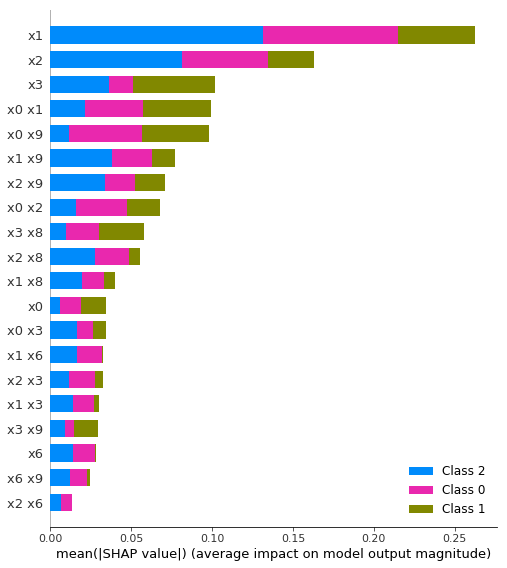

In [9]:
shap.summary_plot(shap_values, X_prep_df)

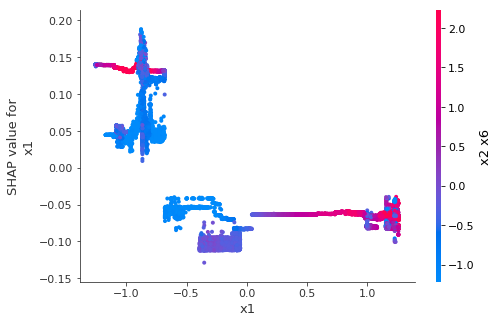

In [11]:
shap.dependence_plot("x1", shap_values[0], X_prep_df)

In [ ]:
# shap.force_plot(shap_values[:1000,:], valid_x.iloc[:1000,:]

In [ ]:
## Generate Predictions
y_hat = gs_classif.best_estimator_.predict(test[['orientation_X','orientation_Y','orientation_Z','orientation_W', \
                                                        'angular_velocity_X','angular_velocity_Y','angular_velocity_Z', \
                                                        'linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z']])

## Transform back to labels
test['surface'] = instance_LabelEncoder.inverse_transform(y_hat)

In [ ]:
## join to submission file
submission = pd.read_csv('sample_submission.csv')
answers = test.groupby('series_id').first()[['surface']]
submission['surface'] = answers['surface']

## save as csv
submission.to_csv('submission_11Apr2019_djs.csv', index=False)